## MNIST with SGD Classifier and Random Forests

#### Setup

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # disable warning
warnings.simplefilter('ignore')

In [2]:
ROOT_DIR = '.'

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#### MNIST

[The MNIST database](http://yann.lecun.com/exdb/mnist/)

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/home/rootofallevil/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/rootofallevil/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Datasets loaded by Scikit-Learn generally has the following structure:
- A `DESCR` key describing the dataset.
- A `data` key containing an array with one row per instance and one column per feature.
- A `target` key containing an array with labels.

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


The dataset contains 70,000 images, each image has 784 features (28 by 28 pixels). Each feature represents one pixel's intensity, from 0 (white) to 255 (black).

0.0


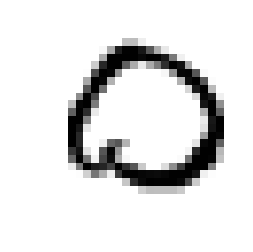

In [28]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, 
              interpolation="nearest")
    plt.axis("off")
    
plot_digit(X[100])
print(y[100])
plt.show()

#### Preparation

The MNIST dataset is already split into a training set (first 60,000 images) and a test set (the last 10,000) images. We  further shuffle the training set to guarantee the effectiveness of cross-validation. 

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier: 0-detector

#### SGD Classifier

We start by trying to identify one digit -- the **0-detector** will check if the number is 0 or not.

In [24]:
y_train_0 = (y_train == 0) ## True for 0 and false otherwise
y_test_0 = (y_test == 0)

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 20)
sgd_clf.fit(X_train, y_train_0)

sgd_clf.predict([X[100]]) # Seems legit?

array([ True])

`SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001)`
- Implements regularized linear models with stochastic gradient descent learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate.
- Default loss function: hinge loss.
- Default regularization penalty: L2
- Default regularization multiplier: 0.0001

#### Random Forest Classifier

Fits a number of decision tree classifiers on various sub-samples of the datasets and uses averaging to improve the predictive accuracy and control overfitting.

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=20)
forest_clf.fit(X_train, y_train_0)

forest_clf.predict([X[100]])

array([ True])

## Measuring Performance

#### Cross Validation

Maximize the use of the available data for training and testing a model. Very useful for accessing model performance.

A good explanation: [Link](https://medium.com/@mtterribile/understanding-cross-validations-purpose-53490faf6a86)


In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_0, cv=5, scoring="accuracy")

array([0.98900092, 0.98908424, 0.98608333, 0.98849904, 0.98624885])

Even though the accuracy seems high, remember we are dealing with a *skewed dataset* -- among all the images, only 1/10 of them are 0 (`True`), which means a model that always outputs `False` will have 90% accuracy!

In [50]:
cross_val_score(forest_clf, X_train, y_train_0, cv=5, scoring="accuracy")

array([0.99266728, 0.99208399, 0.9925    , 0.99133261, 0.99374948])

#### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. 

To clarity the terminologies, consider a cancer-detection device.
- True Positives (TP): you have cancer and it returns True -- correctly predicted True.
- False Positives (FP): you don't have cancer and it returns True -- wrongly predicted True.
- True Negatives (TN): you don't have cancer and it returns False -- correctly predicted False.
- False Negatives (FN): you have cancer and it returns False -- wrongly predicted False.

Each row in a confusion matrix represents an *actual* class, while each column represents a *predicted* class. In our binary classification, $TN = C_{0, 0}, FN= C_{1, 0}, TP = C_{1, 1}, FP = C_{0, 1}$.

Let's test how many times our model mixed 0 with 6. We use `cross_val_predict` to make predicts on each test fold, then inspect the confusion matrix. 

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=5)
confusion_matrix(y_train_0, y_train_pred)

array([[53836,   241],
       [  492,  5431]])

**Result**
- TN: 53836 images are correctly identified as non-0.
- TP: 5431 images are correctly identified as 0.
- FN: 492 images are 0's but failed to be identified.
- FP: 241 images are not 0's but are identified as 0.

Based on these scores, we introduce to measure the performance of the classifier:
- **Precision** measures the accuracy of the positive predictions.
$$
\text{precision} = \frac{TP}{TP+FP}
$$

- **Recall** measures the ratio of positive instances that are correctly detected.
$$
\text{recall} = \frac{TP}{TP+FN}
$$

We can combine precision and recall into one metric called the $F_1$ score, which is the harmonic mean of precision and recall. $F_1$ score is high only if both precision and recall are high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \times \frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}} = \frac{TP}{TP+\frac{FN+FP}{2}}
$$

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_0, y_train_pred)) # 5431 / (5431 + 241)
print(recall_score(y_train_0, y_train_pred)) # 5431 / (5431 + 492)
print(f1_score(y_train_0, y_train_pred)) # 5431 / (5431 + (241 + 492) / 2)

0.9575105782792666
0.9169339861556643
0.936783096162139


#### The ROC Curve

The *receiver operating characteristic* curve plots the *true position rate* (recall) against the *false positive rate*. 
- FPR: false positive rate
- TNR: true negative rate, also called *specificity*

$$
ROC = \frac{TPR}{FPR} = \frac{\text{recall}}{1-\text{specificity}}
$$

## Multiclass Classifier

#### OvA vs. OvO

Some algorithms (e.g., Random Forests and naive Bayes) are capable of handling multiple classes directly, Others (e.g., SVM or Linear classifier) are strictly binary classifiers. Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task and it automatically runs OvA (except for SVM for which it uses OvO).

#### Multiclass SGD Classifier

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and select the class with the highest score. As we can see, the model gives class 0 the highest score.

In [55]:
sgd_clf.fit(X_train, y_train) # this time use the original set of labels, instead of the boolean array y_train_0
print("Class predicted: ", sgd_clf.predict([X[100]]))

decision_array = sgd_clf.decision_function([X[100]])[0]
for i, x in enumerate(decision_array):
    print("Possibility for class %i: %f" % (i, x))

Class predicted:  [0.]
Possibility for class 0: 182405.844228
Possibility for class 1: -909709.967995
Possibility for class 2: -119467.329971
Possibility for class 3: -558166.124092
Possibility for class 4: -1017221.018020
Possibility for class 5: -428571.114416
Possibility for class 6: -439562.132701
Possibility for class 7: -930403.528961
Possibility for class 8: -411360.543381
Possibility for class 9: -1176339.719842


#### Multiclass Random Forest Classifier

In [58]:
forest_clf.fit(X_train, y_train)
print("Class predicted: ", forest_clf.predict([X[100]]))
      
decision_array = forest_clf.predict_proba([X[100]])[0]
for i, x in enumerate(decision_array):
    print("Possibility for class %i: %f" % (i, x))

Class predicted:  [0.]
Possibility for class 0: 1.000000
Possibility for class 1: 0.000000
Possibility for class 2: 0.000000
Possibility for class 3: 0.000000
Possibility for class 4: 0.000000
Possibility for class 5: 0.000000
Possibility for class 6: 0.000000
Possibility for class 7: 0.000000
Possibility for class 8: 0.000000
Possibility for class 9: 0.000000


## Error Analysis

#### Confusion Matrix

**Standard Scaler**
- Standardize features by removing the mean and scaling to unit variance.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)

In [63]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5742,    3,   19,   12,   12,   44,   42,    7,   38,    4],
       [   2, 6466,   46,   32,    6,   40,    8,   12,  119,   11],
       [  60,   40, 5319,  104,   77,   26,  100,   58,  157,   17],
       [  49,   36,  139, 5359,    3,  216,   38,   55,  143,   93],
       [  19,   28,   37,   12, 5354,    9,   56,   35,   79,  213],
       [  79,   41,   29,  198,   83, 4588,  106,   36,  171,   90],
       [  34,   24,   39,    2,   41,   85, 5645,    3,   45,    0],
       [  29,   18,   70,   27,   47,   13,    7, 5814,   18,  222],
       [  57,  154,   74,  163,   14,  149,   53,   25, 5030,  132],
       [  45,   29,   30,   87,  157,   33,    3,  200,   86, 5279]])

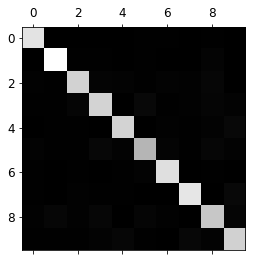

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### Model Error

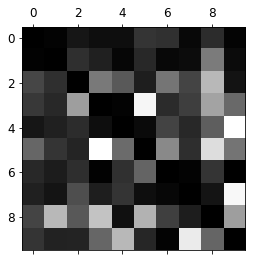

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**Results** 

Recall that rows represent actual classes, while columns represent predicted classes.
- Column 8 and 9 are bright: many images are misclassified as 8 or 9.
- Column 0 and 1 are dark: not many images are misclassified as 0 or 1.
- Row 8 and 9 are bright: many 8 and 9's are confused with other digits. 
- Row 0 and 1 are dark: most 0 and 1's are correctly identified.
- A lot of 4's are classified as 9's. Same for 7 vs. 9 and 5 vs. 3.
- ...



## Measure the Performance on the test set

In [78]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

y_pred = sgd_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       980
           1       0.98      0.91      0.95      1135
           2       0.69      0.94      0.80      1032
           3       0.93      0.80      0.86      1010
           4       0.80      0.95      0.87       982
           5       0.56      0.90      0.69       892
           6       0.97      0.88      0.92       958
           7       0.94      0.84      0.89      1028
           8       0.86      0.50      0.63       974
           9       0.90      0.70      0.79      1009

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.87      0.84      0.84     10000



In [81]:
y_pred = forest_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.92      0.94      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.92      0.92      0.92       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.90      0.92       974
           9       0.94      0.90      0.92      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



The Random Forest classifier performed much better the SGD classifier. To further improve the model, we'll try neural networks. This notebook ends here.